# **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy import stats

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.preprocessing import (
                        StandardScaler, OneHotEncoder, PowerTransformer, 
                        FunctionTransformer, QuantileTransformer
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

import warnings
warnings.filterwarnings('ignore')

-------------------------------------------------------------------------------------------------------------------------

# **Data Overview**

In [2]:
df_raw = pd.read_csv('/kaggle/input/insurance/insurance.csv')
df = df_raw.copy()
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [4]:
df.describe(include='O').T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


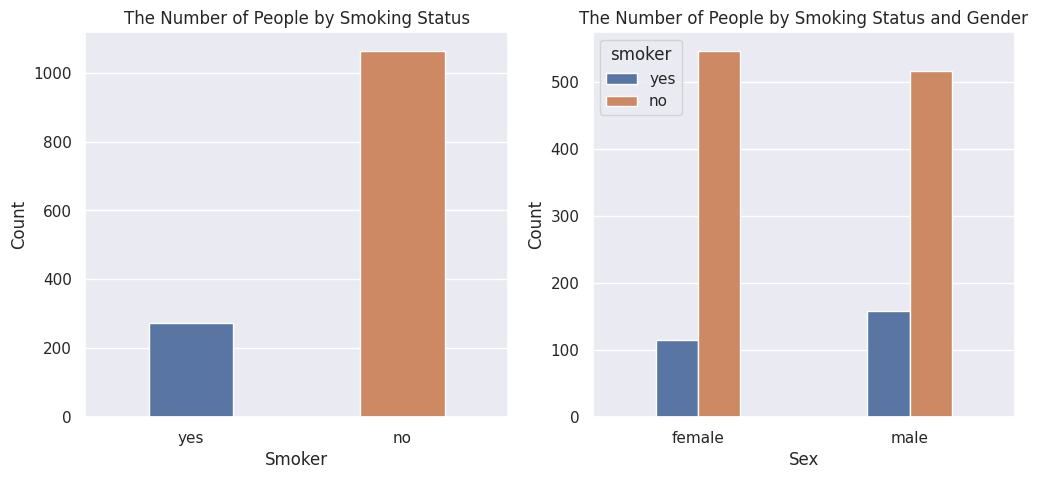

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x='smoker', data=df, width=0.4, ax=ax[0])
_ = ax[0].set(
    title='The Number of People by Smoking Status',
    xlabel='Smoker',
    ylabel='Count'
)

sns.countplot(x='sex', hue='smoker', data=df, width=0.4, ax=ax[1])
_ = ax[1].set(
    title='The Number of People by Smoking Status and Gender',
    xlabel='Sex',
    ylabel='Count'
)

plt.show()

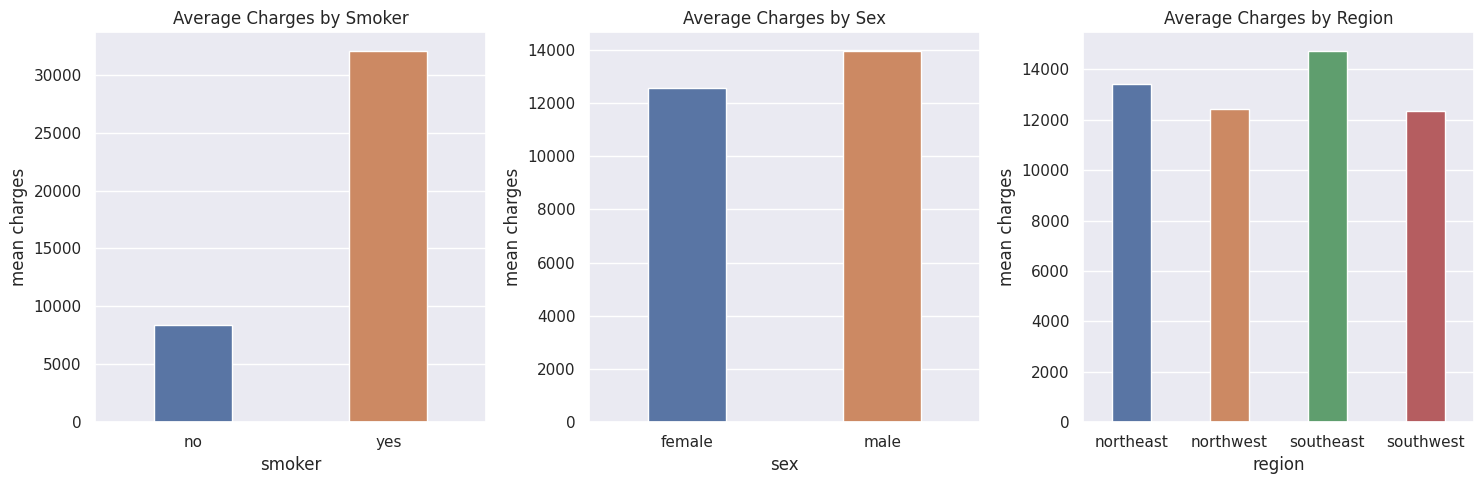

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(['smoker', 'sex', 'region']):
    sns.barplot(x=feature, 
                y='mean charges', 
                data=df.groupby(feature)['charges'].mean()  \
                            .reset_index(name='mean charges'), 
                width=0.4, 
                ax=ax[i])
    
    ax[i].set_title(f'Average Charges by {feature.title()}')

plt.tight_layout()
plt.show()

In [8]:
# Body Mass Index (BMI) categories according to the World Health Organization (WHO)
df['bmi_group'] = pd.cut(df['bmi'],
                            bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')],
                            labels=['Underweight', 'Normal weight', 'Overweight', 
                                    'Obesity I', 'Obesity II', 'Obesity III'])

df['age_group'] = pd.cut(df['age'], 
                         bins=[17, 35, 60, 100], 
                         labels=['18-35', '36-60', '61+'], 
                         right=True)

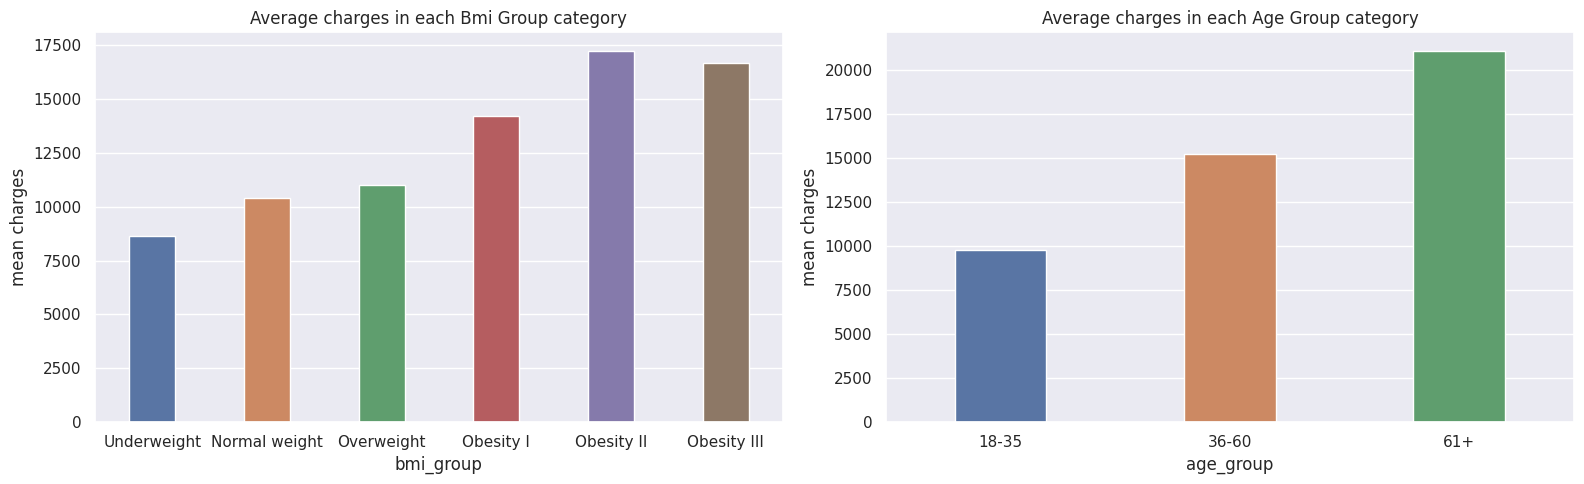

In [9]:
def avg_charges_plot(ax, feature):
    sns.barplot(x=feature,
                y='mean charges',
                data=df.groupby(feature)['charges'].mean()  \
                            .reset_index(name='mean charges'), 
                width=0.4, 
                ax=ax)
    ax.set_title(f"Average charges in each {feature.title().replace('_', ' ')} category")


fig, ax = plt.subplots(1, 2, figsize=(16, 5))
avg_charges_plot(ax[0], feature='bmi_group')
avg_charges_plot(ax[1], feature='age_group')

plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------------------------------------------------------------

# **EDA**

In [10]:
# convert categorical variables with two unique values into binary values (0 and 1)
df['sex'] = (df['sex'] == 'female').astype('int')
df['smoker'] = (df['smoker'] == 'yes').astype('int')

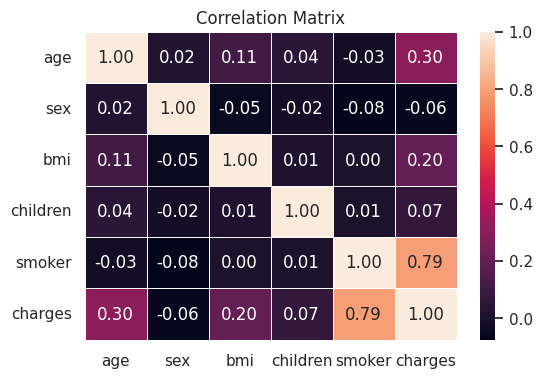

In [11]:
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

**Conclusion**<br>The heatmap reveals no significant correlation (above 0.85) between features, indicating an absence of multicollinearity.

## **Target Variable**

In [12]:
print(f"Skew for `charges`: {df['charges'].skew()}\n"  \
      f"Kurtosis for `charges`: {df['charges'].kurtosis()}")

Skew for `charges`: 1.5158796580240386
Kurtosis for `charges`: 1.6062986532967907


**Meaning**

Kurtosis greater than 0 → This means that the distribution has heavier tails than the normal distribution (a higher number of extreme values).<br>
Skewness greater than 0 → This indicates that the distribution is right-skewed.

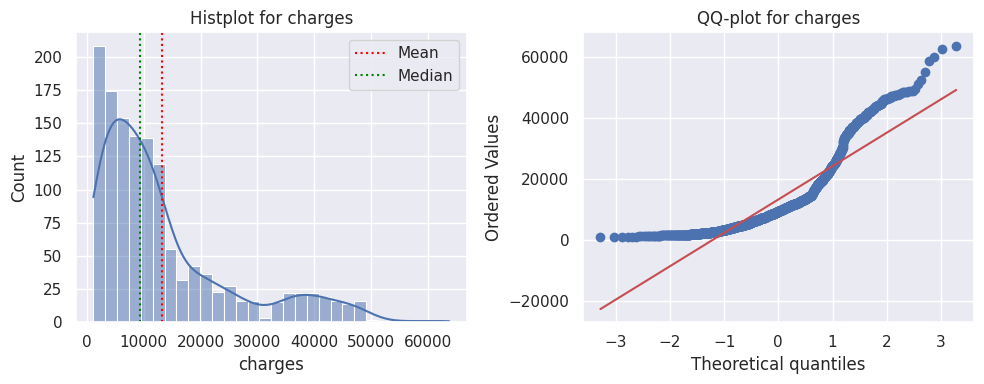

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(df['charges'], bins=30, kde=True, ax=ax[0])
ax[0].axvline(df['charges'].mean(), color='red', linestyle='dotted', label='Mean')
ax[0].axvline(df['charges'].median(), color='green', linestyle='dotted', label='Median')
ax[0].legend()
ax[0].set_title('Histplot for charges')

stats.probplot(df['charges'], dist='norm', plot=ax[1])
ax[1].set_title('QQ-plot for charges')
plt.tight_layout()
plt.show()

When the target has a highly skewed distribution, it can lead to unstable predictions.<br>So, at this stage, we can try to find a transformation that brings the target closer to a normal distribution.

**Shapiro-Wilk Test**

We will test whether the target values come from a normal distribution.

In [14]:
stat, p_value = stats.shapiro(df['charges'])

print('Test statistic:', stat)
print('P-value:', p_value)

if p_value > 0.05:
    print('The data comes from a normal distribution.')
else:
    print('The data does not come from a normal distribution.')

Test statistic: 0.8146881157362383
P-value: 1.1505226334932036e-36
The data does not come from a normal distribution.


**Conclusion**<br>1. The stat value `0.81` is below 1, indicating that the data is somewhat less likely to follow a normal distribution, but it's not drastically different from normality.<br>2. In this case, the p-value is more important because it determines whether we reject the null hypothesis. Even though the test statistic suggests a possible deviation from normality, the p-value indicates that there isn't enough evidence to reject the hypothesis that the data comes from a normal distribution.<br>3. Based on the Shapiro-Wilk test, we should be cautious with the Quantile Transformer, as it may distort outliers. If outliers are important for predictions, the transformation could harm performance. It's crucial to test and evaluate its impact on the model.

**Important**<br>Tests like these offer useful insights, but they don’t directly predict model performance, as results depend on various factors. It’s essential to empirically test different approaches to determine what works best for your specific problem.

In [15]:
df[df['charges'] <= 0]

,age,sex,bmi,children,smoker,region,charges,bmi_group,age_group


Since there are no negative values in the charges column, we can apply the following transformations:

1. log
2. sqrt
3. box-cox
4. quantile


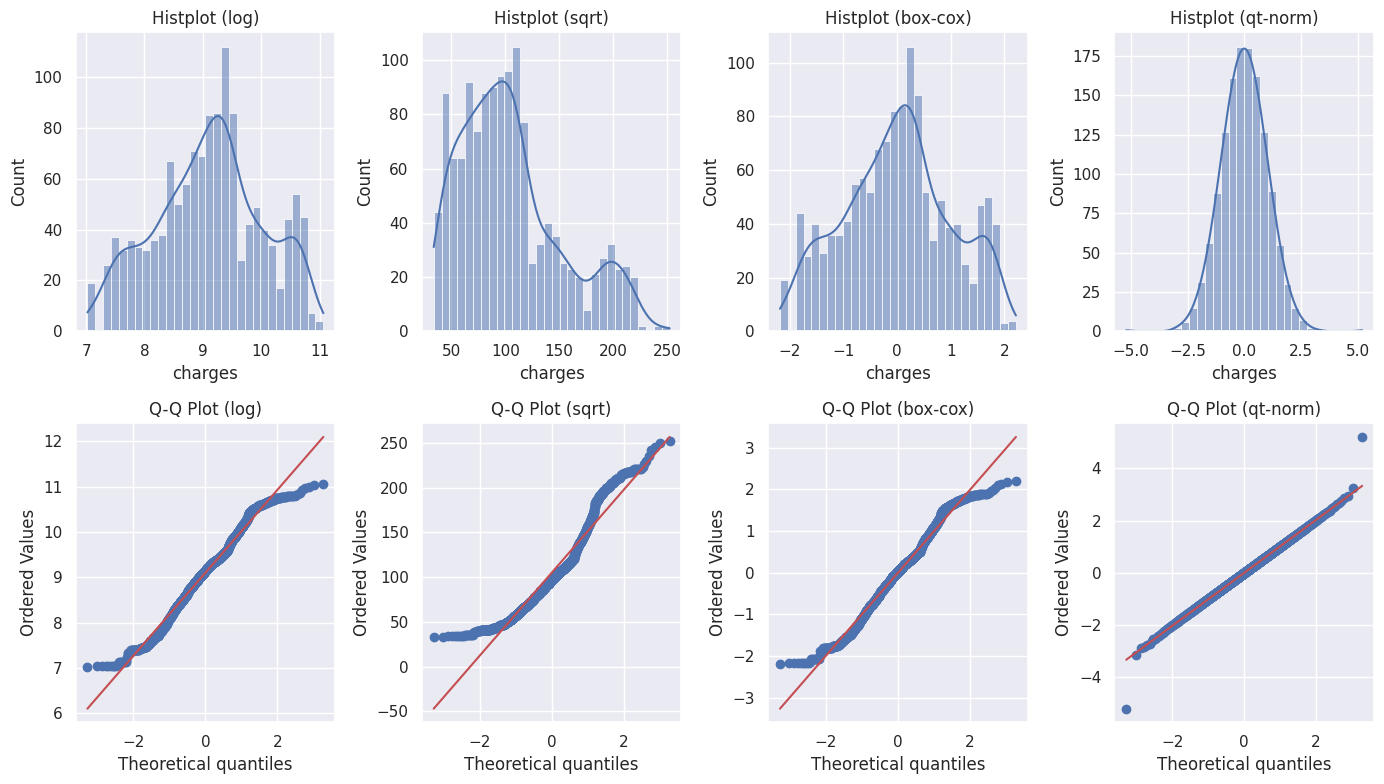

In [16]:
def transform_target(target: pd.Series) -> None:
    """
    This function performs different transformations on the input target variable,
    and displays both histograms and Q-Q plots for each transformed version.
    """
    transformations = {
        'log': lambda x: np.log(x), 
        'sqrt': lambda x: np.sqrt(x),
        'box-cox': lambda x: PowerTransformer(method='box-cox')  \
                                  .fit_transform(x.values.reshape(-1, 1)).flatten(),
        
        'qt-norm': lambda x: QuantileTransformer(output_distribution='normal')  \
                                  .fit_transform(x.values.reshape(-1, 1)).flatten()
    }

    fig, axes = plt.subplots(2, len(transformations), figsize=(14, 2 * len(transformations)))

    for i, key in enumerate(transformations.keys()):
        transformed = transformations[key](target)
        
        sns.histplot(transformed, bins=30, kde=True, ax=axes[0, i])
        axes[0, i].set_title(f'Histplot ({key})')
        axes[0, i].set_xlabel('charges')

    for i, key in enumerate(transformations.keys()):
        transformed = transformations[key](target)
        
        stats.probplot(transformed, plot=axes[1, i])
        axes[1, i].set_title(f'Q-Q Plot ({key})')

    plt.tight_layout()
    plt.show()

transform_target(df['charges'])

**Conclusion**<br>In the modeling process, we will test the Log transformation and Quantile transformation.

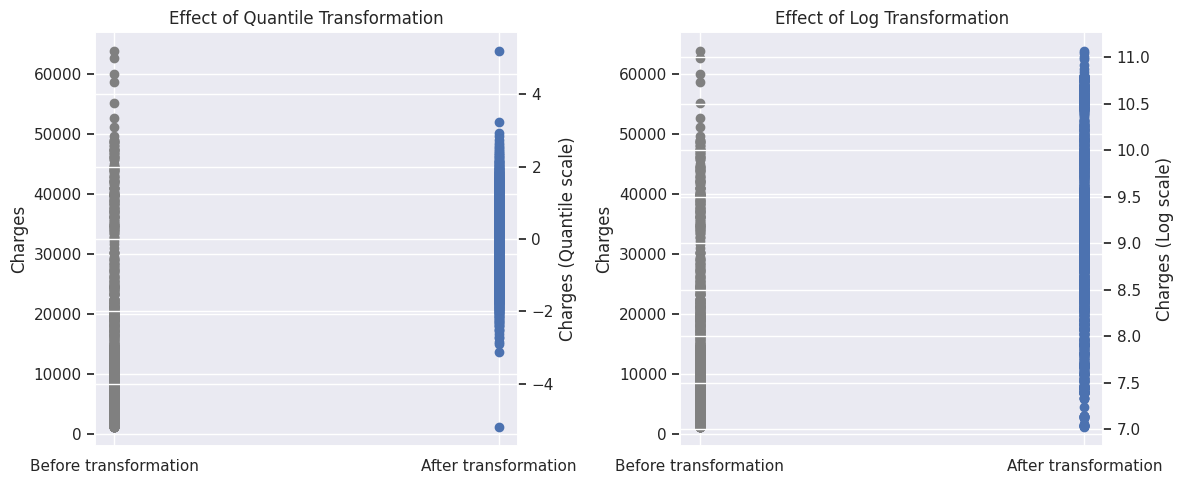

In [17]:
quantile_trans = QuantileTransformer(output_distribution='normal').fit_transform(df['charges'].values.reshape(-1, 1))
log_trans = np.log(df['charges'])

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 5))

# quantile-transformation 
zeros_q = np.zeros_like(df['charges'])
ones_q = np.ones_like(quantile_trans)

ax.scatter(zeros_q, df['charges'], color='gray')
ax.set_title('Effect of Quantile Transformation')

ax_q = ax.twinx()
ax_q.scatter(ones_q, quantile_trans)
ax_q.set_ylabel('Charges (Quantile scale)')


# log-transformation 
zeros_log = np.zeros_like(df['charges'])
ones_log = np.ones_like(log_trans)

ax1.scatter(zeros_log, df['charges'], color='gray')
ax1.set_title('Effect of Log Transformation')

ax1_log = ax1.twinx()
ax1_log.scatter(ones_log, log_trans)
ax1_log.set_ylabel('Charges (Log scale)')


for axis in [ax, ax1]:
    axis.set(
        ylabel='Charges',
        xticks=[0, 1],
        xticklabels=['Before transformation', 'After transformation'],
    )

plt.tight_layout()
plt.show()

## **Feature Variables**

In [18]:
corr_matrix['charges']

age         0.299008
sex        -0.057292
bmi         0.198341
children    0.067998
smoker      0.787251
charges     1.000000
Name: charges, dtype: float64

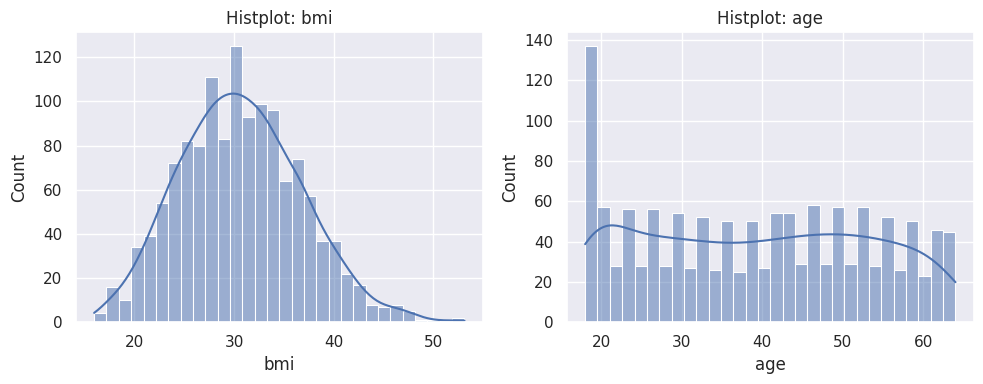

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, col in enumerate(['bmi', 'age']):
    sns.histplot(df[col], 
                 bins=30, 
                 kde=True, 
                 ax=ax[i])
    ax[i].set_title(f'Histplot: {col}')

plt.tight_layout()
plt.show()

**Conslusion**<br>Analysis of explanatory variables shows that:

*  bmi has an almost normal distribution with a slight right skew, which should not significantly affect model performance
*  age retains its discrete distribution, consistent with expectations for this type of variable

Thus, removing outliers is unnecessary, as the transformation has already mitigated their impact. 

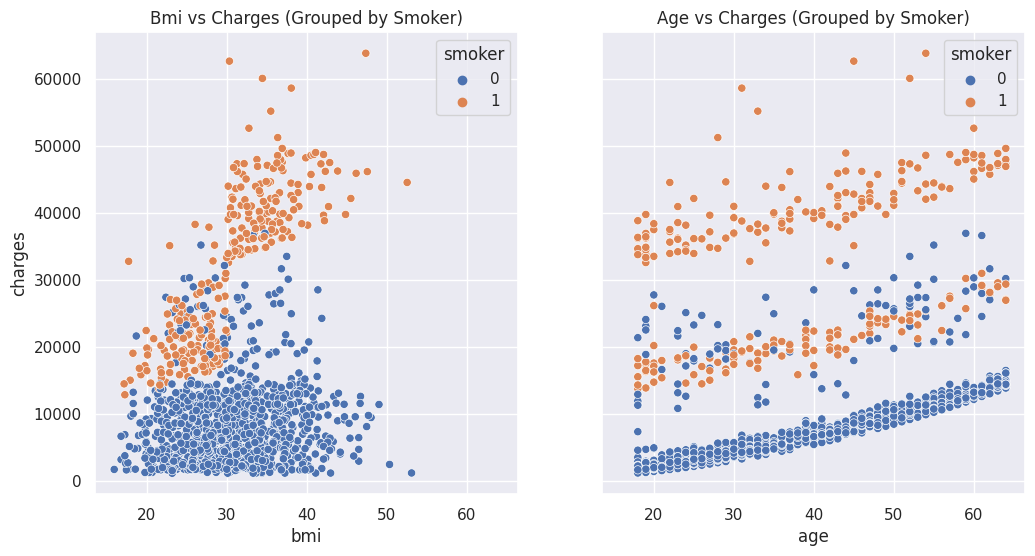

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)

for i, col in enumerate(['bmi', 'age']):
    sns.scatterplot(x=col, 
                    y='charges', 
                    hue='smoker', 
                    data=df,
                    ax=ax[i])
    
    ax[i].set_title(f'{col.title()} vs Charges (Grouped by Smoker)')

plt.show()

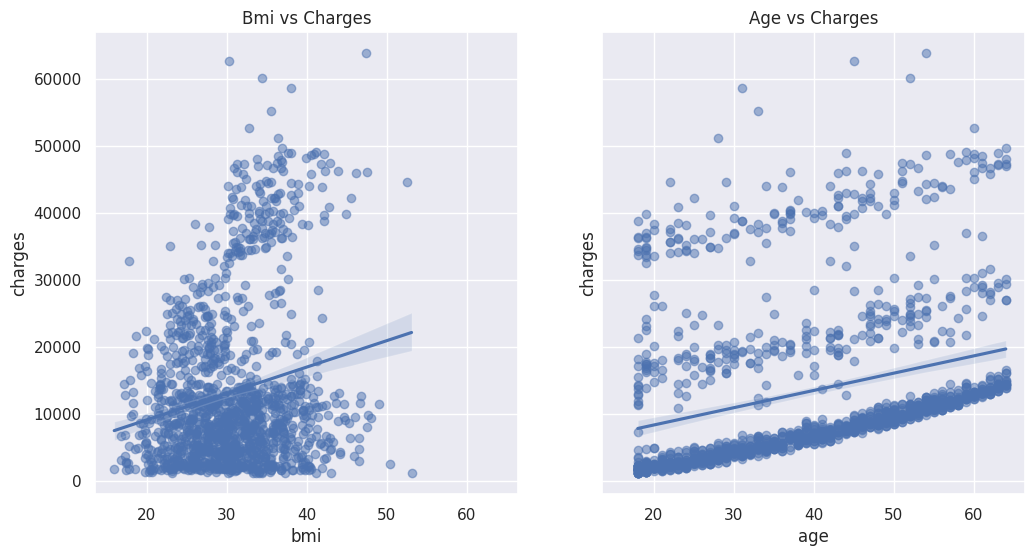

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)

for i, col in enumerate(['bmi', 'age']):
    sns.regplot(x=col, 
                y='charges',
                data=df,
                scatter_kws={'alpha':0.5}, 
                ax=ax[i])

    ax[i].set_title(f'{col.title()} vs Charges')

plt.show()

At this stage, we can already observe the general trend of the regression lines, which give an initial indication of how the variables `BMI` and `age` are expected to relate to medical charges across the entire dataset.

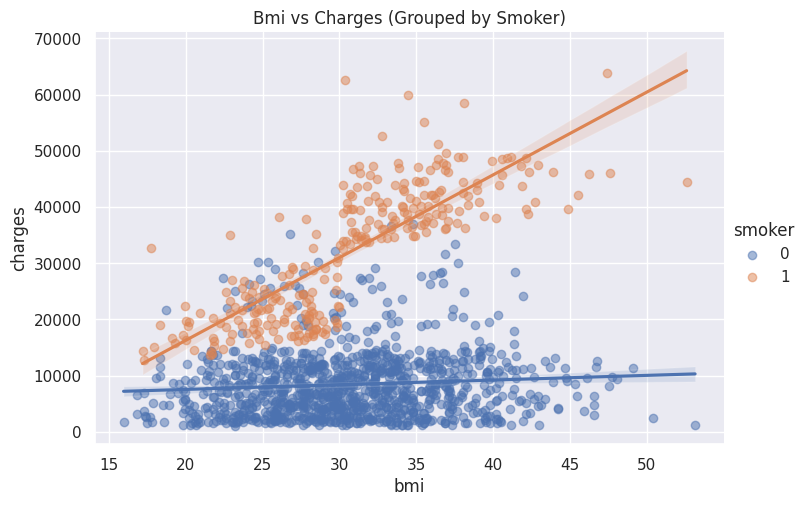

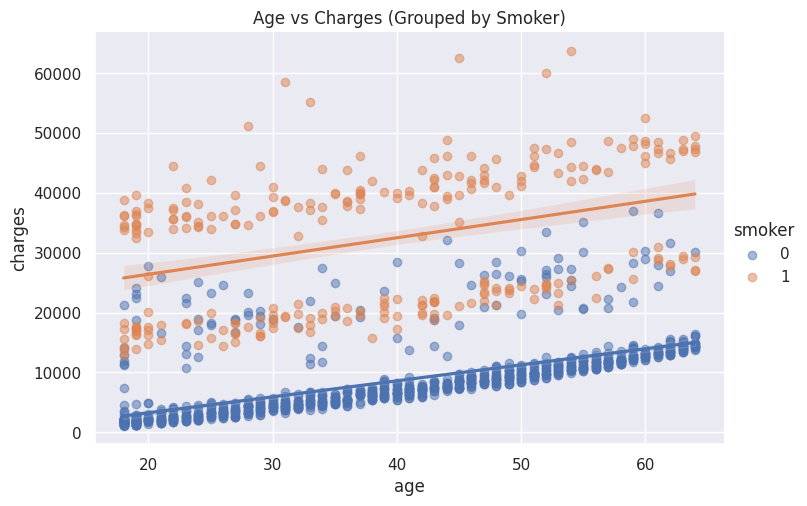

In [22]:
for col in ['bmi', 'age']:
    sns.lmplot(x=col, 
               y='charges', 
               hue='smoker', 
               data=df, 
               height=5, 
               aspect=1.5, 
               scatter_kws={'alpha':0.5})

    plt.title(f'{col.title()} vs Charges (Grouped by Smoker)')
    plt.show()


At this stage, we can already observe how the regression lines will behave when considering the dataset separately for smokers and non-smokers, based on the `BMI` and `age` variable.


### **Grouping**

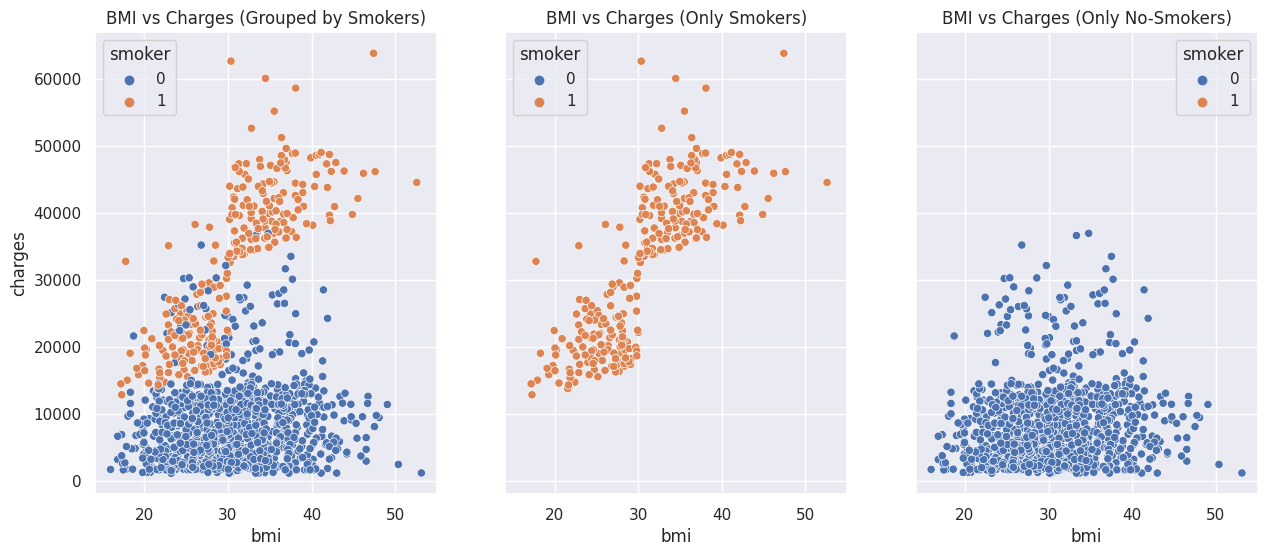

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6), sharey=True, sharex=True)
sns.scatterplot(x=df['bmi'], 
                y=df['charges'], 
                hue=df['smoker'],
                ax=ax[0])

sns.scatterplot(x=df[df['smoker'] == 1]['bmi'], 
                y=df[df['smoker'] == 1]['charges'], 
                hue=df['smoker'],
                ax=ax[1])

sns.scatterplot(x=df[df['smoker'] == 0]['bmi'], 
                y=df[df['smoker'] == 0]['charges'], 
                hue=df['smoker'], 
                ax=ax[2])

ax[0].set_title('BMI vs Charges (Grouped by Smokers)')
ax[1].set_title('BMI vs Charges (Only Smokers)')
ax[2].set_title('BMI vs Charges (Only No-Smokers)')

plt.show()

In [24]:
df_smoker = df[df['smoker'] == 1]
df_no_smoker = df[df['smoker'] == 0]

----------------------------------------------------------------------------------

# **Modeling**

## **Functions for Model Pipeline Setup**

In [25]:
def create_lr_pipeline(lr_features: dict, group: bool=False) -> Pipeline:
    """
    Creates a pipeline for a Linear regressor with custom preprocessing.
    """
    bin_features = lr_features.get('bin', []).copy()
    if group:
        bin_features.remove('smoker')
    
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), lr_features.get('num', [])),
        ('bin', 'passthrough', bin_features),
        ('cat', OneHotEncoder(
            drop='first', 
            sparse_output=False, 
            handle_unknown='ignore'
        ), lr_features.get('cat', []))
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ])

    return pipeline


def create_knn_pipeline(knn_features: dict, group: bool=False) -> Pipeline:
    """
    Creates a pipeline for a K-Nearest Neighbor regressor with custom preprocessing.
    """
    bin_features = knn_features.get('bin', []).copy()
    if group:
        bin_features.remove('smoker')
        
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), knn_features.get('num', [])),
        ('bin', 'passthrough', bin_features),
        ('cat', OneHotEncoder(
            drop='first', 
            sparse_output=False, 
            handle_unknown='ignore'
        ), knn_features.get('cat', []))
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_regression)),
        ('model', KNeighborsRegressor())
    ])

    return pipeline


def create_dt_pipeline(dt_features: dict, group: bool=False) -> Pipeline:
    """
    Creates a pipeline for a Decision Tree regressor with custom preprocessing.
    """
    rest_features = dt_features.get('rest', []).copy()
    if group:
        rest_features.remove('smoker')
    
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), dt_features.get('cat', [])),
        ('rest', 'passthrough', rest_features)
    ])
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', DecisionTreeRegressor())
    ])

    return pipeline


def create_rf_pipeline(rf_features: dict, group: bool=False) -> Pipeline:
    """
    Creates a pipeline for a Random Forest regressor with custom preprocessing.
    """
    rest_features = rf_features.get('rest', []).copy()
    if group:
        rest_features.remove('smoker')

    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), rf_features.get('cat', [])),
        ('rest', 'passthrough', rest_features)
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor())
    ])

    return pipeline


## **Function for Applying Target Transformations**

In [26]:
def evalute_target_transformers(inner_pipeline: Pipeline, param_grid: dict):
    """
    A generator that applies different target transformations (log, quantile, none)
    by wrapping the given inner_pipeline with a TransformedTargetRegressor
    and adjusting the parameter grid accordingly.

    This is mainly used for models like KNN and LinearRegression.
    """
    for name, config in transformations.items():
        local_param_grid = param_grid.copy()
        
        print('-'*60)
        print(f'Evaluating [{name}] transformer')

        pipeline = TransformedTargetRegressor(
            regressor=inner_pipeline,
            transformer=config['transformer']
        ) if config['transformer'] is not None else inner_pipeline

        if isinstance(config['transformer'], QuantileTransformer):
            # update param_grid with params for quantile transformer
            local_param_grid.update(config['param_grid'])


        if config['transformer'] is not None:
            local_param_grid = {
                k.replace('model__', 'regressor__model__'): v 
                for k, v in local_param_grid.items()
            }

        yield pipeline, local_param_grid

## **Functions for Model Evaluation and Tuning**

In [27]:
def create_train_test_results(
    y_train: pd.Series, 
    y_test: pd.Series, 
    y_train_pred: np.ndarray, 
    y_test_pred: np.ndarray,
) -> pd.DataFrame:
    """
    Calculates and shows performance metrics (R2, MAE, MSE, RMSE) for both 
    training and test datasets.
    """
    print('\n🎯 Prediction scores:')
    print(pd.DataFrame({
        'dataset': [
            'train', 
            'test'
        ],
        'r2': [
            r2_score(y_train, y_train_pred), 
            r2_score(y_test, y_test_pred)
        ],
        'mae': [
            mean_absolute_error(y_train, y_train_pred),
            mean_absolute_error(y_test, y_test_pred)
        ],
        'mse': [
            mean_squared_error(y_train, y_train_pred),
            mean_squared_error(y_test, y_test_pred)
        ],
        'rmse': [
            np.sqrt(mean_squared_error(y_train, y_train_pred)),
            np.sqrt(mean_squared_error(y_test, y_test_pred))
        ]
    }))

def perform_cross_validation(
    pipeline: Pipeline, 
    *,
    config: dict,
    group: str,
    X_train: pd.DataFrame, 
    X_test: pd.DataFrame, 
    y_train: pd.Series, 
    y_test: pd.Series, 
    cv: KFold
) -> dict[str]:
    """
    Performs cross-validation on the provided pipeline, evaluating it using the specified metrics,
    and prints the train and test performance scores. Then It displays cross-validation results along with 
    performance metrics for both training and test datasets.
    """
    scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True)

    results = {}
    for metric in scoring.keys():
        results[f'train_{metric}'] = scores[f'train_{metric}']
        results[f'test_{metric}'] = scores[f'test_{metric}']

    print('\n🔁 Cross-validation scores:') 
    print(pd.DataFrame(results))

    
    pipeline.fit(X_train, y_train)
    y_test_pred = pipeline.predict(X_test)
    y_train_pred = pipeline.predict(X_train)

    # show metrics for train and test
    create_train_test_results(y_train, y_test, y_train_pred, y_test_pred)
   
    return {
        'Algorithm': config['model'].__name__,
        'Group': group,
        'Best_Score': scores['test_r2'].mean(),
        'Folds_Scores': [round(score, 3) for score in scores['test_r2']],
        'Best_Params': None,  # No best_params for cross-validation
        'Train_R2': r2_score(y_train, pipeline.predict(X_train)),
        'Test_R2': r2_score(y_test, pipeline.predict(X_test))
    }
    

def perform_grid_search(
    pipeline: Pipeline, 
    param_grid: dict[str, list], 
    *, 
    config: dict,
    group: str,
    X_train: pd.DataFrame, 
    X_test: pd.DataFrame, 
    y_train: pd.Series, 
    y_test: pd.Series, 
    cv: KFold
) -> dict[str]:
    """
    Performs GridSearchCV to tune hyperparameters and evaluates the model using 
    cross-validation and test data. Then It displays cross-validation results along with 
    performance metrics for both training and test datasets.
    """
    grid_search = GridSearchCV(pipeline, 
                               param_grid, 
                               cv=cv,
                               scoring=scoring, 
                               refit=list(scoring.keys())[0], 
                               return_train_score=True)
    
    grid_search.fit(X_train, y_train)
    y_test_pred = grid_search.best_estimator_.predict(X_test)
    y_train_pred = grid_search.best_estimator_.predict(X_train)

    cv_results = grid_search.cv_results_
    best_idx = grid_search.best_index_

    folds_data = []
    for i in range(cv.get_n_splits()):
        fold_data = {}
        for metric in scoring.keys():
            fold_data[f'train_{metric}'] = cv_results[f'split{i}_train_{metric}'][best_idx]
            fold_data[f'test_{metric}'] = cv_results[f'split{i}_test_{metric}'][best_idx]
        folds_data.append(fold_data)

    print("\n🔁 GridSearch cross-validation scores:")
    print(pd.DataFrame(folds_data))

    # show metrics for train and test
    create_train_test_results(y_train, y_test, y_train_pred, y_test_pred)
    
    return {
        'Algorithm': config['model'].__name__,
        'Group': group,
        'Best_Score': grid_search.best_score_,
        'Folds_Scores': [round(grid_search.cv_results_[f'split{i}_test_r2'][grid_search.best_index_], 3)
                         for i in range(grid_search.cv.get_n_splits())],
        'Best_Params': grid_search.best_params_,
        'Train_R2': r2_score(y_train, grid_search.best_estimator_.predict(X_train)),
        'Test_R2': r2_score(y_test, grid_search.best_estimator_.predict(X_test))
    }


def get_pipeline_scores(
    X_train: pd.DataFrame, 
    X_test: pd.DataFrame, 
    y_train: pd.Series, 
    y_test: pd.Series, 
    group: str
) -> pd.DataFrame:
    """
    Evaluates multiple models with either GridSearchCV or Cross-Validation based on the configuration provided 
    in the `model_config`. Optionally applies target transformations, and returns a DataFrame of results sorted by 
    Test R2 score.
    """
    df_results = pd.DataFrame()
    for model, config in model_config.items():
        print()
        print('='*60)
        print(f"\nTesting model: {config['model'].__name__}")
        
        # create pipeline with specified features for each model
        pipeline = config['pipeline'](config, group=True) if group != 'all' else config['pipeline'](config)

        # get config values
        model = config['model']
        param_grid = config['param_grid']
        
        # add cv settings
        cv = KFold(
            n_splits=cv_config.get('n_splits', 5), 
            shuffle=cv_config.get('shuffle', False), 
            random_state=cv_config.get('random_state', None)
        )

        results = []

        def run_pipeline(pipeline, param_grid, X_train, X_test, y_train, y_test, cv):
            """
            Executes a pipeline with either GridSearchCV or Cross-Validation 
            based on the provided parameter grid.
            """
            if param_grid:
                return perform_grid_search(pipeline,
                                          param_grid,
                                          config=config,
                                          group=group,
                                          X_train=X_train, 
                                          X_test=X_test, 
                                          y_train=y_train, 
                                          y_test=y_test,
                                          cv=cv)
            
            return perform_cross_validation(pipeline,
                                            config=config,
                                            group=group,
                                            X_train=X_train, 
                                            X_test=X_test, 
                                            y_train=y_train, 
                                            y_test=y_test, 
                                            cv=cv)
                
        # check if this model need target transformation
        if config['target_transformation']:
            # run pipeline with target transformations
            for transformed_pipeline, local_param_grid in evalute_target_transformers(pipeline, param_grid):
                res = run_pipeline(transformed_pipeline, local_param_grid, X_train, X_test, y_train, y_test, cv)
                results.append(res)
        # run pipeline without target transformations                
        else:
            res = run_pipeline(pipeline, param_grid, X_train, X_test, y_train, y_test, cv)
            results.append(res)
            
        df_res = pd.DataFrame(results)
        df_results = pd.concat([df_results, df_res], axis=0, ignore_index=True)

    return df_results.sort_values(by='Test_R2', ascending=False)

## **Model Configuration and Evaluation Setup**

In [28]:
model_config = {
    'lr': {
        'model': LinearRegression,
        'num': ['age', 'bmi'],
        'bin': ['sex', 'smoker'],
        'cat': ['children', 'region'],
        'target_transformation': True,
        'pipeline': create_lr_pipeline,
        'param_grid': {}
    },
   
    'knn': {
        'model': KNeighborsRegressor,
        'num': ['age', 'bmi'],
        'bin': ['sex', 'smoker'],
        'cat': ['children', 'region'],
        'target_transformation': True,
        'pipeline': create_knn_pipeline,
        'param_grid': {
            'model__n_neighbors': [3, 5, 7],
            'model__weights': ['uniform', 'distance'],
            # 'model__leaf_size': [5, 10, 20],
        }
    },
    
    'dt': {
        'model': DecisionTreeRegressor,
        'cat': ['children', 'region'],
        'rest': ['age', 'bmi', 'sex', 'smoker'],
        'target_transformation': False,
        'pipeline': create_dt_pipeline,
        'param_grid': {
            'model__max_depth': [5, 10, 15, 20],
            'model__min_samples_split': [10, 25, 50, 100],
            'model__min_samples_leaf': [5, 10, 25, 50],
        }
    },
    
    'rf': {
        'model': RandomForestRegressor,
        'cat': ['children', 'region'],
        'rest': ['age', 'bmi', 'sex', 'smoker'],
        'target_transformation': False,
        'pipeline': create_rf_pipeline,
        'param_grid': {
            'model__n_estimators': [25, 40, 50, 60],
            'model__max_depth': [3, 5, 7, 10],
            'model__min_samples_split': [12, 16, 20, 24],
            'model__min_samples_leaf': [6, 8, 10, 12]
        }
    }
}


cv_config = {
    'n_splits': 5,
    'shuffle': True,
    'random_state': 42,
}


scoring = {
    'r2': 'r2',  # The first metric will be used by GridSearch to select the best model
    'nrmse': 'neg_root_mean_squared_error',
    'nmae': 'neg_mean_absolute_error',
}


transformations = {
    'log': {
        'transformer': FunctionTransformer(np.log, inverse_func=np.exp),
        'param_grid': {}
    },
    'quantile': {
        'transformer': QuantileTransformer(output_distribution='normal'),
        'param_grid': {
            'transformer__n_quantiles': [100, 500, 1000],
        }
    },
    'none': {
        'transformer': None,
        'param_grid': {}
    }
}

## **Main Function: Execution and Evaluation Workflow**

In [29]:
def main():
    groups = {
        'all': (
            df.drop(['charges'], axis=1), 
            df['charges']
        ),
        'smoker': (
            df_smoker.drop(['smoker', 'charges'], axis=1), 
            df_smoker['charges']
        ),
        'no_smoker': (
            df_no_smoker.drop(['smoker', 'charges'], axis=1), 
            df_no_smoker['charges']
        ),
    }
    df_all_results = pd.DataFrame()

    for key, (X, y) in groups.items():
        print(f'\n📂 DATASET GROUP: {key}')

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        df_all_results = pd.concat([
            df_all_results, get_pipeline_scores(X_train, X_test, y_train, y_test, group=key)
        ], axis=0, ignore_index=True) 
        
    return df_all_results
    
main()


📂 DATASET GROUP: all


Testing model: LinearRegression
------------------------------------------------------------
Evaluating [log] transformer

🔁 Cross-validation scores:
   train_r2   test_r2  train_nrmse   test_nrmse   train_nmae    test_nmae
0  0.501941  0.533967 -8362.331474 -8622.805913 -4274.418231 -4526.016325
1  0.526459  0.422335 -8260.304134 -9157.829543 -4300.949297 -4775.847436
2  0.535420  0.484263 -8269.597811 -8226.574191 -4351.456643 -4104.227631
3  0.518028  0.580154 -8356.458080 -7723.457962 -4307.372545 -4083.926611
4  0.499097  0.485543 -8521.609719 -8540.231345 -4379.424843 -4433.528464

🎯 Prediction scores:
  dataset        r2          mae           mse         rmse
0   train  0.516026  4315.970257  6.985375e+07  8357.855300
1    test  0.615072  3896.665949  5.975964e+07  7730.435879
------------------------------------------------------------
Evaluating [quantile] transformer

🔁 GridSearch cross-validation scores:
   train_r2   test_r2  train_nrmse   test_nrms

,Algorithm,Group,Best_Score,Folds_Scores,Best_Params,Train_R2,Test_R2
0,RandomForestRegressor,all,0.858024,"[0.825, 0.853, 0.903, 0.837, 0.873]","{'model__max_depth': 7, 'model__min_samples_leaf': 12, 'model__min_samples_split': 16, 'model__n_estimators': 25}",0.882759,0.875565
1,DecisionTreeRegressor,all,0.852318,"[0.825, 0.841, 0.895, 0.824, 0.876]","{'model__max_depth': 5, 'model__min_samples_leaf': 25, 'model__min_samples_split': 10}",0.866883,0.862139
2,KNeighborsRegressor,all,0.703994,"[0.665, 0.636, 0.743, 0.722, 0.754]","{'regressor__model__n_neighbors': 3, 'regressor__model__weights': 'distance', 'transformer__n_quantiles': 100}",0.997988,0.784368
3,LinearRegression,all,0.735791,"[0.729, 0.698, 0.774, 0.71, 0.768]",None,0.743213,0.782566
4,KNeighborsRegressor,all,0.702612,"[0.659, 0.671, 0.735, 0.715, 0.733]","{'model__n_neighbors': 5, 'model__weights': 'distance'}",0.998306,0.751364
5,KNeighborsRegressor,all,0.698806,"[0.601, 0.596, 0.737, 0.783, 0.777]","{'regressor__model__n_neighbors': 3, 'regressor__model__weights': 'distance'}",0.997870,0.750444
6,LinearRegression,all,0.635604,"[0.694, 0.568, 0.613, 0.619, 0.684]",{'transformer__n_quantiles': 1000},0.644871,0.727886
7,LinearRegression,all,0.501253,"[0.534, 0.422, 0.484, 0.58, 0.486]",None,0.516026,0.615072
8,DecisionTreeRegressor,smoker,0.845328,"[0.92, 0.887, 0.814, 0.836, 0.77]","{'model__max_depth': 5, 'model__min_samples_leaf': 10, 'model__min_samples_split': 10}",0.920369,0.881915
9,RandomForestRegressor,smoker,0.874087,"[0.933, 0.89, 0.886, 0.843, 0.818]","{'model__max_depth': 10, 'model__min_samples_leaf': 6, 'model__min_samples_split': 12, 'model__n_estimators': 60}",0.926301,0.879285


------------------------------------------------------------------------------------------------------------

### Results summary:

1. By analyzing the fold scores, we can assess the stability of a given algorithm. If the values are highly varied, it indicates that the model is less stable.
2. The Train_R2 represents the R² score calculated on the training data, and by comparing it with Test_R2, we can check whether the model is overfitting.<br>For KNN, the training set scores will always be around 1.0 (100%) because the model stores all training data and later compares new inputs to it during predictions.
3. Regarding group segmentation, it didn't work as expected. For the 'smokers' group, most algorithms performed well, but for the 'non-smokers' group,<br>the results were the opposite, with algorithms struggling to find a good fit.